# Outlook

In this notebook, using BBRL, we code a simple version of the DQN algorithm without a replay buffer nor a target network so as to better understand the inner mechanisms. To understand this code, you need to know more about BBRL. You should first have a look at [the BBRL interaction model](https://colab.research.google.com/drive/1_yp-JKkxh_P8Yhctulqm0IrLbE41oK1p?usp=sharing), then [a first example](https://colab.research.google.com/drive/1Ui481r47fNHCQsQfKwdoNEVrEiqAEokh?usp=sharing) and, most importantly, [details about the data collection implementation](https://colab.research.google.com/drive/1W9Y-3fa6LsPeR6cBC1vgwBjKfgMwZvP5?usp=sharing).

## Installation and Imports

### Installation

The BBRL library is [here](https://github.com/osigaud/bbrl).

This is OmegaConf that makes it possible that by just defining the `def run_dqn(cfg):` function and then executing a long `params = {...}` variable at the bottom of this colab, the code is run with the parameters without calling an explicit main.

More precisely, the code is run by calling

`config=OmegaConf.create(params)`

`run_dqn(config)`

at the very bottom of the colab, after starting tensorboard.

In [ ]:
import os
import functools
import time
!pip install omegaconf
from omegaconf import OmegaConf

import gym
!pip install git+https://github.com/osigaud/my_gym.git
!pip install git+https://github.com/osigaud/bbrl.git

import bbrl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 79 kB 3.3 MB/s 
     |████████████████████████████████| 596 kB 9.1 MB/s 
     |████████████████████████████████| 117 kB 57.3 MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144575 sha256=400cd647db61c63dbdce79423a91049f22f9d7ec83053e1ebe0bb17ec73dcd21
  Stored in directory: /root/.cache/pip/wheels/8b/8d/53/2af8772d9aec614e3fc65e53d4a993ad73c61daa8bbd85a873
Successfully built antlr4-python3-runtime
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/osigaud/my_gym.git to /tmp/pip-req-build-_m3jbgjk
  Running command git clone -q https://github.com/osigaud/my_gym.git /tmp/pip-req-build-_m3jbgjk
  Cloning https://github.com/osigaud/SimpleMazeMDP.git to /tmp/pip-install-1wkjhwy6/mazemdp_7081df0d68904fabbc2e8e9d424f72da
  Running command git clone -q https://github.com/osigaud/SimpleMazeMDP.git /tmp/pip-install-1wkjhwy6/mazemdp_7081df0d68904fabbc2e8e9d424f72da
     |████████████████████████████████| 1.5 MB 4.3 MB/s 
     |████████████████████████████████| 1.3 MB 34.7 MB/s 
  Created wheel for my-gym: filename=my_gym-0.0.1-py3-none-any.whl size=13929 sha256=08834f12e7426b2a316450a97ac6da55b13899ac99d6099e5f359f11201ab8bc
  Stored in directory: /tmp/pip-ephem-wheel-cache-4h_3r2xm/wheels/1c/6c/5c/ae7a2f747d7e4018a92c506849842cf048d83e7bf07fa2b7b5
  Created wheel for mazemdp: filename=mazemdp-0.0.0-py3-none-any.w

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/osigaud/bbrl.git to /tmp/pip-req-build-s2363atd
  Running command git clone -q https://github.com/osigaud/bbrl.git /tmp/pip-req-build-s2363atd
  Cloning https://github.com/osigaud/my_gym.git to /tmp/pip-install-jci2nhr2/my-gym_05da83a270054651a8098a11618bb8b3
  Running command git clone -q https://github.com/osigaud/my_gym.git /tmp/pip-install-jci2nhr2/my-gym_05da83a270054651a8098a11618bb8b3
     |████████████████████████████████| 1.0 MB 4.2 MB/s 
     |████████████████████████████████| 151 kB 46.6 MB/s 
     |████████████████████████████████| 219 kB 51.9 MB/s 
  Cloning https://github.com/osigaud/SimpleMazeMDP.git to /tmp/pip-install-jci2nhr2/mazemdp_bd8d07170c9547eca8afb8645e52cdc2
  Running command git clone -q https://github.com/osigaud/SimpleMazeMDP.git /tmp/pip-install-jci2nhr2/mazemdp_bd8d07170c9547eca8afb8645e52cdc2
  Created wheel for bbrl: filename=b

### Imports

Below, we import standard python packages, pytorch packages and gym environments.

[OpenAI gym](https://gym.openai.com/) is a collection of benchmark environments to evaluate RL algorithms.

In [ ]:
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F

import gym

### BBRL imports

In [ ]:
from bbrl.agents.agent import Agent
from bbrl import get_arguments, get_class, instantiate_class

# The workspace is the main class in BBRL, this is where all data is collected and stored
from bbrl.workspace import Workspace

# Agents(agent1,agent2,agent3,...) executes the different agents the one after the other
# TemporalAgent(agent) executes an agent over multiple timesteps in the workspace, 
# or until a given condition is reached
from bbrl.agents import Agents, RemoteAgent, TemporalAgent

# AutoResetGymAgent is an agent able to execute a batch of gym environments
# with auto-resetting. These agents produce multiple variables in the workspace: 
# ’env/env_obs’, ’env/reward’, ’env/timestep’, ’env/done’, ’env/initial_state’, ’env/cumulated_reward’, 
# ... When called at timestep t=0, then the environments are automatically reset. 
# At timestep t>0, these agents will read the ’action’ variable in the workspace at time t − 1
from bbrl.agents.gymb import AutoResetGymAgent, NoAutoResetGymAgent
# Not present in the A2C version...
from bbrl.utils.logger import TFLogger

## Definition of agents

The [DQN](https://daiwk.github.io/assets/dqn.pdf) algorithm is a critic only algorithm. Thus we just need a Critic agent (which will also be used to output actions) and an Environment agent. We reuse the `DiscreteQAgent` class that we have already explained in [a previous notebook](https://colab.research.google.com/drive/1Ui481r47fNHCQsQfKwdoNEVrEiqAEokh?usp=sharing).

In [ ]:
def build_mlp(sizes, activation, output_activation=nn.Identity()):
    layers = []
    for j in range(len(sizes) - 1):
        act = activation if j < len(sizes) - 2 else output_activation
        layers += [nn.Linear(sizes[j], sizes[j + 1]), act]
    return nn.Sequential(*layers)

In [ ]:
class DiscreteQAgent(Agent):
    def __init__(self, state_dim, hidden_layers, action_dim):
        super().__init__()
        self.model = build_mlp(
            [state_dim] + list(hidden_layers) + [action_dim], activation=nn.ReLU()
        )

    def forward(self, t, choose_action=True, **kwargs):
        obs = self.get(("env/env_obs", t))
        q_values = self.model(obs).squeeze(-1)
        self.set(("q_values", t), q_values)
        if choose_action:
            action = q_values.argmax(1)
            self.set(("action", t), action)

In [ ]:
def make_env(env_name):
    return gym.make(env_name)

### Creating an Exploration method

As Q-learning, DQN needs some exploration to prevent too early convergence. Here we will use the simple $\epsilon$-greedy exploration method. The method is implemented as an agent which chooses an action based on the Q-values.

In [ ]:
class EGreedyActionSelector(Agent):
    def __init__(self, epsilon):
        super().__init__()
        self.epsilon = epsilon

    def forward(self, t, **kwargs):
        q_values = self.get(("q_values", t))
        nb_actions = q_values.size()[1]
        size = q_values.size()[0]
        is_random = torch.rand(size).lt(self.epsilon).float()
        random_action = torch.randint(low=0, high=nb_actions, size=(size,))
        max_action = q_values.max(1)[1]
        action = is_random * random_action + (1 - is_random) * max_action
        action = action.long()
        self.set(("action", t), action)

### Training and evaluation environments

We build two environments: one for training and another one for evaluation.

For training, it is more efficient to use an AutoResetGymAgent, as we do not want to waste time if the task is done in an environment sooner than in the others.

By contrast, for evaluation, we just need to perform a fixed number of episodes (for statistics), thus it is more convenient to use a NoAutoResetGymAgent with a set of environments and just run one episode in each environment. Thus we can use the `env/done` stop variable and take the average over the cumulated reward of all environments.


See [this notebook](https://colab.research.google.com/drive/1Ui481r47fNHCQsQfKwdoNEVrEiqAEokh?usp=sharing) for explanations about agents and environment agents.

In [ ]:
def get_env_agents(cfg):
    train_env_agent = AutoResetGymAgent(
        get_class(cfg.gym_env),
        get_arguments(cfg.gym_env),
        cfg.algorithm.n_envs,
        cfg.algorithm.seed,
    )
    eval_env_agent = NoAutoResetGymAgent(
    get_class(cfg.gym_env),
    get_arguments(cfg.gym_env),
    cfg.algorithm.nb_evals,
    cfg.algorithm.seed,
    )
    return train_env_agent, eval_env_agent

### Create the DQN agent

Interestingly, the loop between the policy and the environment is first defined as a collection of agents, and then embedded into a single TemporalAgent.

In [ ]:
def create_dqn_agent(cfg, train_env_agent, eval_env_agent):
    obs_size, act_size = train_env_agent.get_obs_and_actions_sizes()
    critic = DiscreteQAgent(obs_size, cfg.algorithm.architecture.hidden_size, act_size)
    explorer = EGreedyActionSelector(cfg.algorithm.epsilon)
    q_agent = TemporalAgent(critic)
    tr_agent = Agents(train_env_agent, critic, explorer)
    ev_agent = Agents(eval_env_agent, critic)

    # Get an agent that is executed on a complete workspace
    train_agent = TemporalAgent(tr_agent)
    eval_agent = TemporalAgent(ev_agent)
    train_agent.seed(cfg.algorithm.seed)
    return train_agent, eval_agent, q_agent

### The Logger class

Explanations for the logger were already given in [this notebook](https://colab.research.google.com/drive/1raeuB6uUVUpl-4PLArtiAoGnXj0sGjSV?usp=sharing).

In [ ]:
class Logger():

  def __init__(self, cfg):
    self.logger = instantiate_class(cfg.logger)

  def add_log(self, log_string, loss, epoch):
    self.logger.add_scalar(log_string, loss.item(), epoch)

  # Log losses
  def log_losses(self, cfg, epoch, critic_loss, entropy_loss, a2c_loss):
    self.add_log("critic_loss", critic_loss, epoch)
    self.add_log("entropy_loss", entropy_loss, epoch)
    self.add_log("a2c_loss", a2c_loss, epoch)


### Setup the optimizers

We use a single optimizer to tune the parameters of the actor (in the prob_agent part) and the critic (in the critic_agent part). It would be possible to have two optimizers which would work separately on the parameters of each component agent, but it would be more complicated because updating the actor requires the gradient of the critic.

In [ ]:
# Configure the optimizer over the q agent
def setup_optimizers(cfg, q_agent):
    optimizer_args = get_arguments(cfg.optimizer)
    parameters = q_agent.parameters()
    optimizer = get_class(cfg.optimizer)(parameters, **optimizer_args)
    return optimizer

### Compute critic loss

Detailed explanations of the function to compute the critic loss when using a NoAutoResetGymAgent are given in [this notebook](https://colab.research.google.com/drive/1raeuB6uUVUpl-4PLArtiAoGnXj0sGjSV).

The case where we use the AutoResetGymAgent is very similar, but we need to specify that we use the first part of the Q-values (`q_values[0]`) for representing $Q(s_t,a_t)$ and the second part (`q_values[1]`) for representing $Q(s_{t+1},a)$, as these values are stored into a transition model.

In [ ]:
def compute_critic_loss(cfg, reward, must_bootstrap, q_values, action):
    # Compute temporal difference
    max_q = q_values[1].max(-1)[0].detach()
    target = reward[:-1] + cfg.algorithm.discount_factor * max_q * must_bootstrap.int()
    act = action[0].unsqueeze(-1)
    qvals = torch.gather(q_values[0], dim=1, index=act).squeeze()
    td = target - qvals
    # Compute critic loss
    td_error = td**2
    critic_loss = td_error.mean()
    return critic_loss, td

## Main training loop

Note that everything about the shared workspace between all the agents is completely hidden under the hood. This results in a gain of productivity, at the expense of having to dig into the BBRL code if you want to understand the details, change the multiprocessing model, etc.

### Agent execution

This is the tricky part with BBRL, the one we need to understand in detail. The difficulty lies in the copy of the last step and the way to deal with the n_steps return.

The call to `train_agent(workspace, t=1, n_steps=cfg.algorithm.n_timesteps - 1, stochastic=True)` makes the agent run a number of steps in the workspace. In practice, it calls the [__call__()](https://github.com/osigaud/bbrl/blob/master/bbrl/agents/agent.py#L54) function which makes a forward pass of the agent network using the workspace data and updates the workspace accordingly.

Now, if we start at the first epoch (`epoch=0`), we start from the first step (`t=0`). But when subsequently we perform the next epochs (`epoch>0`), we must not forget to cover the transition at the border between the previous epoch and the current epoch. To avoid this risk, we copy the information from the last time step of the previous epoch into the first time step of the next epoch. This is explained in more details in [a previous colab](https://colab.research.google.com/drive/1W9Y-3fa6LsPeR6cBC1vgwBjKfgMwZvP5).

The [previous colab](https://colab.research.google.com/drive/1W9Y-3fa6LsPeR6cBC1vgwBjKfgMwZvP5) explains a lot of these details. In particular, read it to understand the `execute_agents(...)` function, the `transition_workspace = train_workspace.get_transitions()` line and the computation of `must_bootstrap`.

Note that we `optimizer.zero_grad()`, `loss.backward()` and `optimizer.step()` lines. `optimizer.zero_grad()` is necessary to cancel all the gradients computed at the previous iterations


In [ ]:
def run_dqn(cfg, max_grad_norm=0.5):
    # 1)  Build the  logger
    logger = Logger(cfg)
    best_reward = -10e9

    # 2) Create the environment agent
    train_env_agent, eval_env_agent = get_env_agents(cfg)

    # 3) Create the DQN-like Agent
    train_agent, eval_agent, q_agent = create_dqn_agent(
        cfg, train_env_agent, eval_env_agent
    )

    # 5) Configure the workspace to the right dimension
    # Note that no parameter is needed to create the workspace.
    # In the training loop, calling the agent() and critic_agent()
    # will take the workspace as parameter
    train_workspace = Workspace()  # Used for training

    # 6) Configure the optimizer over the a2c agent
    optimizer = setup_optimizers(cfg, q_agent)
    nb_steps = 0
    tmp_steps = 0

    # 7) Training loop
    for epoch in range(cfg.algorithm.max_epochs):
        # Execute the agent in the workspace
        if epoch > 0:
            train_workspace.zero_grad()
            train_workspace.copy_n_last_steps(1)
            train_agent(
                train_workspace, t=1, n_steps=cfg.algorithm.n_steps - 1, stochastic=True
            )
        else:
            train_agent(
                train_workspace, t=0, n_steps=cfg.algorithm.n_steps, stochastic=True
            )

        transition_workspace = train_workspace.get_transitions()

        q_values, done, truncated, reward, action = transition_workspace[
            "q_values", "env/done", "env/truncated", "env/reward", "action"
        ]

        nb_steps += len(action[0]) * cfg.algorithm.n_envs

        # Determines whether values of the critic should be propagated
        # True if the episode reached a time limit or if the task was not done
        # See https://colab.research.google.com/drive/1erLbRKvdkdDy0Zn1X_JhC01s1QAt4BBj
        must_bootstrap = torch.logical_or(~done[1], truncated[1])

        # Compute critic loss
        critic_loss, td = compute_critic_loss(
            cfg, reward, must_bootstrap, q_values, action
        )

        # Store the loss for tensorboard display
        logger.add_log("critic_loss", critic_loss, nb_steps)

        optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(q_agent.parameters(), max_grad_norm)
        optimizer.step()

        if nb_steps - tmp_steps > cfg.algorithm.eval_interval:
            tmp_steps = nb_steps
            eval_workspace = Workspace()  # Used for evaluation
            eval_agent(
                eval_workspace, t=0, stop_variable="env/done", choose_action=True
            )
            rewards = eval_workspace["env/cumulated_reward"][-1]
            mean = rewards.mean()
            logger.add_log("reward", mean, nb_steps)
            print(f"epoch: {epoch}, reward: {mean}")
            if cfg.save_best and mean > best_reward:
                best_reward = mean
                directory = "./dqn0_critic/"
                if not os.path.exists(directory):
                    os.makedirs(directory)
                filename = directory + "dqn0_" + str(mean.item()) + ".agt"
                eval_agent.save_model(filename)


## Definition of the parameters

The logger is defined as `bbrl.utils.logger.TFLogger` so as to use a tensorboard visualisation.

In [ ]:
params={
  "save_best": False,
  "logger":{
    "classname": "bbrl.utils.logger.TFLogger",
    "log_dir": "./tmp/" + str(time.time()),
    "cache_size": 10000,
    "every_n_seconds": 10,
    "verbose": False,    
    },

  "algorithm":{
    "seed": 5,
    "epsilon": 0.02,
    "n_envs": 1,
    "n_steps": 100,
    "eval_interval": 2000,
    "nb_evals": 10,
    "gae": 0.8,
    "max_epochs": 5000,
    "discount_factor": 0.99,
    "architecture":{"hidden_size": [256, 256]},
  },
  "gym_env":{
    "classname": "__main__.make_env",
    "env_name": "CartPole-v1",
  },
  "optimizer":
  {
    "classname": "torch.optim.Adam",
    "lr": 2e-3,
  }
}

### Launching tensorboard to visualize the results

In [ ]:
%load_ext tensorboard
%tensorboard --logdir ./tmp
config=OmegaConf.create(params)
run_dqn(config)

The version used in this colab uses $< s_t, a_t, r_t, s_{t+1}>$ samples. As an exercise, you may switch to $< s_t, a_t, r_{t+1}, s_{t+1}>$ samples, going back to the standard SaLinA notation. For that, replace the import to `bbrl.agents.gyma` instead of `gymb`, and change the temporal difference update rule (in `compute_critic_loss(...)`) accordingly. See [this notebook](https://colab.research.google.com/drive/1W9Y-3fa6LsPeR6cBC1vgwBjKfgMwZvP5) for more explanations.

## What's next?

Starting from the above version , you can do the following:
- Add a target network, as in [this notebook](https://colab.research.google.com/drive/1raeuB6uUVUpl-4PLArtiAoGnXj0sGjSV#scrollTo=paHdoNlz9Lpg).
- Add a replay buffer. This can be done independently from adding the target network. The version with a replay buffer and no target network corresponds to [the NQF algorithm](https://link.springer.com/content/pdf/10.1007/11564096_32.pdf)
- Add a few extra-mechanisms: starting to learning once the replay buffer is full enough, decreasing the exploration rate epsilon...
- Visualize the learned Q network

## Experimental comparison

If you compare all the versions where:
- DQN naked is "dqn_no_rb_no_target"
- DQN with just the target network is "dqn_no_rb"
- DQN with just the replay buffer is "dqn_no_target" (it is also nfq for Neural Fitted Q-Network, the curves are superimposed)
- DQN with the replay buffer and the target network but no other trick is "dqn_rb_target"
- the full DQN with all the extra mechanisms is "dqn_full"

then you should obtain something like the image below

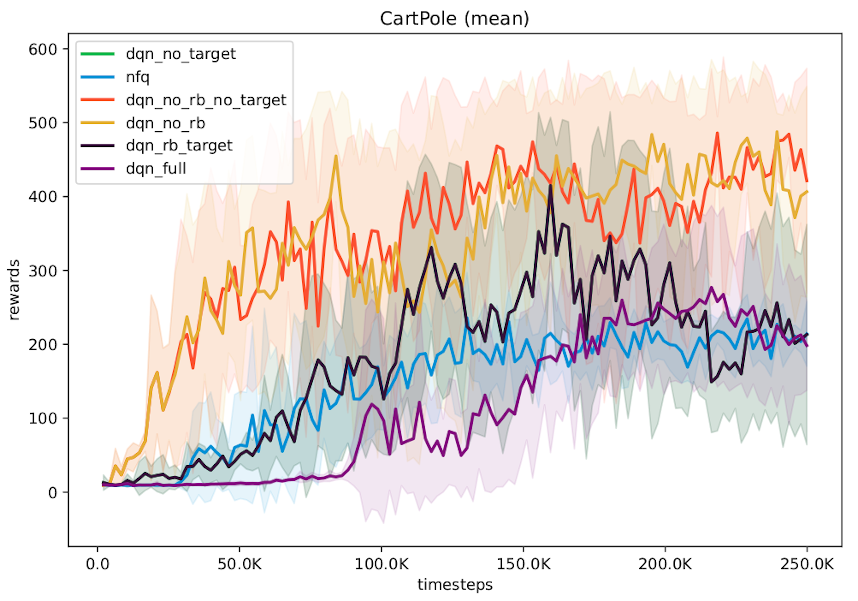

What is surprising is that the naked version works better than the rest. In fact, adding a target network and a replay buffer is meant to stabilize the learning process, but it also makes it slower. Thus, in CartPole where no stabilization is necessary (because the problem is easy), adding these mechanisms is detrimental to performance.

This should not be the same story with more difficult environments.